In [133]:
import requests
from collections import defaultdict
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.spatial import Voronoi, voronoi_plot_2d


import geopandas as gpd
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.polygon import Polygon
import shapely.geometry
import shapely.ops
from shapely.geometry import Point

from geovoronoi import voronoi_regions_from_coords
from scipy.spatial import Voronoi, voronoi_plot_2d

from bokeh.plotting import figure, show, output_file
from bokeh.models import GeoJSONDataSource

In [2]:
def load_data(pages = 725, save=False):
    """
    Loops through all pages of the API of garbage containers and stores these in a DF.
    The fraction and coordinates are saved with the unique id.
    """

    # Formation of variables to be filled in loop
    containers = []
    coordinates = []
    type_vuil = []
    counter = 0
    container_ids = []
    lons_new = []
    lats_new = []

    # Initial link to send GET request to
    link = 'https://api.data.amsterdam.nl/vsd/afvalcontainers'

    # While loop to get all pages
    while link != None and counter < pages: #100 as limit for testing purpose
        counter += 1 #Update counter
        response = requests.get(link) # Send request
        output = response.json()
        for result in output['results']:
            try:
                containers.append(result)
                container_ids.append(result['container_id'])
    #             lons_new.append(float(result['container_wgs84_lon']))
    #             lats_new.append(float(result['container_wgs84_lat']))
                lons_new.append(result['container_geometrie']['coordinates'][0])
                lats_new.append(result['container_geometrie']['coordinates'][1])
                type_vuil.append(result['container_afvalfractie'])
            except:
                print('a')
                pass 
        try:
            link = output['_links']['next']['href'] # Get link to next page

        except:
            link = None

    df= pd.DataFrame([container_ids, lons_new, lats_new, type_vuil]).T.rename(columns={0: 'id', 1:'x', 2:'y', 3:'fractie'})
    
    if save:
        df.to_csv('/../data/containers.csv')
    return df, containers

In [3]:
# Load the dataframe and create 2d np-arrays of all fractions
df, containers = load_data(pages=725)
df = df.dropna()

a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a
a


In [4]:
# street_map = gpd.read_file('../data/sd2010zw_region.shp')
# polygons = list(street_map['geometry'].values)
# multi = MultiPolygon(polygons)

# street_map2 = gpd.read_file('../data/woonsd09_region.shp')
# polygons2 = list(street_map2['geometry'].values)
# multi2 = MultiPolygon(polygons2)

In [5]:
# poly_shapes, pts, poly_to_pt_assignments = voronoi_regions_from_coords(rest, multi)

In [6]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def nn(x, y, pos, neg):
    v = np.array([[x, y]])
    p = np.sum(np.power(pos - v, 2), axis=1)
    n = np.sum(np.power(neg - v, 2), axis=1)
    return np.min(p) < np.min(n)

def plot_voronoi(multi, points, min_vals, max_vals, off=0.5):
    """
    Plots the given points as a voronoi diagram using min_vals and max_vals
    as boundaries for the plot.
    """
    fig = plt.figure(figsize=(16,12))
    axis = fig.add_subplot()
    polygons = []

    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    # Create map of Amsterdam
    for geom in multi:
        xs, ys = geom.exterior.xy
        axis.fill(xs, ys, alpha=0.2, fc='grey', ec='red')
        
    # Create map of inhabited parts of Amsterdam
    for geom in multi2:
        xs, ys = geom.exterior.xy
        axis.fill(xs, ys, alpha=0.2, fc='grey', ec='red')
    
    # Mark containers
    axis.plot(points[:, 0], points[:, 1], 'b+')
    
    # fill polygons with colour
    for region in regions:
        polygon = vertices[region]
        polygons.append(Polygon(polygon))
        axis.fill(*zip(*polygon), fc='none', ec='white', alpha=0.5)
            
    plt.xlim(min_vals[0]-off, max_vals[0]+off)
    plt.ylim(min_vals[1]-off, max_vals[1]+off)
    plt.title('Voronoi diagram of Textile container in Amsterdam')
    plt.show()
    return polygons

In [7]:
# textiel = np.delete(textiel, 284, 0)
# polygons = plot_voronoi(multi, textiel, np.array([110000, 475000]), np.array([135000, 495000]))

In [69]:
def create_voronoi_bokeh(containers, to_plot=True):
    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
    p = figure(tools= TOOLS, x_range=(110000, 135000), y_range=(475000, 495000), plot_width = 750, plot_height=600)
    
    street_map = gpd.read_file('../data/woonbc12_region.shp')
    street_map3 = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    street_map3 = street_map3[street_map3['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    geosource2 = GeoJSONDataSource(geojson = street_map.to_json())
    geosource3 = GeoJSONDataSource(geojson = street_map3.to_json())
    p.patches('xs', 'ys', source=geosource2, fill_color='whitesmoke', line_color='grey')
    p.patches('xs', 'ys', source=geosource3, fill_color='lightgray', line_color='grey')
    
    vor = Voronoi(containers)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    polygons = []
    for region in regions:
        polygon = vertices[region]
        polygons.append(Polygon(polygon))
    
    if to_plot:
        tmp = gpd.GeoDataFrame(polygons).rename(columns={0:'geometry'})
        geosource = GeoJSONDataSource(geojson = tmp.to_json())
        p.patches('xs', 'ys', source=geosource, fill_color='grey', line_color='black', alpha=0.2, line_width=0.1)
        p.circle(containers[:,0], containers[:,1], color='red', radius=6)
        show(p)
    return polygons

In [68]:
def create_voronoi_all_fractions(df):
    df = df.dropna()
    
    papier = df[df['fractie'] == 'Papier']
    rest = df[df['fractie'] == 'Rest']
    plastic = df[df['fractie'] == 'Plastic']
    glas = df[df['fractie'] == 'Glas']
    textiel = df[df['fractie'] == 'Textiel']

    papier = np.column_stack([papier['x'], papier['y']])
    rest = np.column_stack([rest['x'], rest['y']])
    textiel = np.column_stack([textiel['x'], textiel['y']])
    textiel = np.delete(textiel, 284, 0) #dont know why, but this makes it work
    plastic = np.column_stack([plastic['x'], plastic['y']])
    glas = np.column_stack([glas['x'], glas['y']])
    
    polygons_textiel = create_voronoi_bokeh(textiel, to_plot=False)
    polygons_papier = create_voronoi_bokeh(papier, to_plot=False)
    polygons_rest = create_voronoi_bokeh(rest, to_plot=False)
    polygons_glas = create_voronoi_bokeh(glas, to_plot=False)
    polygons_plastic = create_voronoi_bokeh(plastic, to_plot=False)
    
    return papier, rest, textiel, plastic, glas, polygons_textiel, polygons_papier, polygons_rest, polygons_glas, polygons_plastic

papier, rest, textiel, plastic, glas, polygons_textiel, polygons_papier, polygons_rest, polygons_glas, polygons_plastic = create_voronoi_all_fractions(df) 

In [10]:
# lst = []
# for polygon in polygons:
#     lst.append(polygon.area)
# srs = pd.Series(lst)
# srs= [srs[srs < 99999]]
# sns.distplot(srs).set(title='distribution of areas of cells for general waste', xlabel='m2')

In [11]:
def assign_points_to_cell(polygons, containers, grid_points):
    dct = defaultdict(list)
    for point in grid_points:
        for i in range(len(polygons)):
            if polygons[i].contains(point):
                dct[str(containers[i])].append(point)
    return dct
                
def create_grid_points(size=100, prnt=False, only_rest_included=True, inhabited_areas=True):
    """
    This function returns coordinates in the form of a grid of coordinates that fall within the inhabited
    parts of Amsterdam. These points can function as samples to calculate average walking distance to nearest container.
    
    prnt: whether or not to print the amount of points (default false)
    only_rest_included: only include areas where rest garbage is to be dumped in containers (default True)
    inhabited_areas:  
    """
    
    street_map2 = gpd.read_file('../data/woonbc12_region.shp')
    street_map = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
    if only_rest_included:
        street_map = street_map[street_map['aanbiedwij'] == 'Breng uw restafval  naar een container voor restafval.']
    true_points = []
    return_points = []
    points = []
    for i in range(110000, 135000, size):
        for j in range(475000, 495000, size):
            points.append(Point(i, j))

    # Check if points are within the spaces where huisvuil is collecte
    for k in range(street_map.shape[0]):
        try:
            polygon = MultiPolygon(street_map['geometry'].iloc[k]) # If neighborhood is multiple seperated pieces
        except:
            polygon = Polygon(street_map['geometry'].iloc[k]) # Other cases
        [true_points.append(point) for point in points if polygon.contains(point) == True]
        
        
    # Check if points are within inhabited spaces
    if inhabited_areas:
        for k in range(street_map2.shape[0]):
            try:
                polygon = MultiPolygon(street_map2['geometry'].iloc[k]) # If neighborhood is multiple seperated pieces
            except:
                polygon = Polygon(street_map2['geometry'].iloc[k]) # Other cases
            [return_points.append(point) for point in true_points if polygon.contains(point) == True]
    else:
        return_points = true_points

    if prnt:
        print(len(true_points))
        print(len(return_points))
    return return_points

def distribution_to_distance(tmp):
    total = 0
    for k, v in tmp.items():
        container = k.lstrip('[').rstrip(']').split(' ')
        container = Point(float(container[0]), float(container[1]))
        for point in v:
            distance = point.distance(container)
            total += distance
#     print(total, total/len(grid_points))
    return total/len(grid_points)
    

In [83]:
grid_points = create_grid_points(size=600, only_rest_included=True, prnt=True, inhabited_areas=True) 

509
149


In [84]:
# textiel_dict = assign_points_to_cell(polygons_textiel, textiel, grid_points)
# plastic_dict = assign_points_to_cell(polygons_plastic, plastic, grid_points)
# rest_dict = assign_points_to_cell(polygons_rest, rest, grid_points)
# papier_dict = assign_points_to_cell(polygons_papier, papier, grid_points)
# glas_dict = assign_points_to_cell(polygons_glas, glas, grid_points)

In [123]:
def total(df, prnt=False):
    papier, rest, textiel, plastic, glas, polygons_textiel, polygons_papier, polygons_rest, polygons_glas, polygons_plastic = create_voronoi_all_fractions(df)
#     grid_points = create_grid_points(size=1000, only_rest_included=True, prnt=False, inhabited_areas=True)
    textiel_dict = assign_points_to_cell(polygons_textiel, textiel, grid_points)
    plastic_dict = assign_points_to_cell(polygons_plastic, plastic, grid_points)
    rest_dict = assign_points_to_cell(polygons_rest, rest, grid_points)
    papier_dict = assign_points_to_cell(polygons_papier, papier, grid_points)
    glas_dict = assign_points_to_cell(polygons_glas, glas, grid_points)

    results = []
    for i in [textiel_dict, plastic_dict, rest_dict, papier_dict, glas_dict]:
        results.append(distribution_to_distance(i))

    total = 0.05 * results[0] + 0.25 * results[1] + 0.35 * results[2] + 0.2 * results[3] + 0.15 * results[4]
    if prnt:
        print(results)
    return total

total(df, prnt = True)

[290.4860977138719, 162.83773530897037, 91.37634901564347, 138.72219838350404, 147.4007433952198]


137.07001205439516

### Shuffle + Hillclimber

In [86]:
def shuffle_fractions(df):
    df2 = copy.deepcopy(df).reset_index()
    lst = df['fractie'].values
    random.shuffle(lst)
    df2['fractie'] = lst 
    return df2

In [118]:
def hillclimber(old, old_total):
    new = copy.deepcopy(old)
    lst = list(old['fractie'].values)
    first = 0
    second = 0
    
    while first == second:
        try:
            first_number = random.randrange(0,len(lst))
            first = lst[first_number]
            second_number = random.randrange(0,len(lst)) 
            second = lst[second_number]
#             print(first, second)
        except:
            pass
    lst[first_number] = second
    lst[second_number] = first
    new['fractie'] = lst
    new_total = total(new)
    print(old_total, new_total)
    if new_total < old_total:
        print("success")
        return new, new_total
    else:
        print("failure")
        return old, old_total

In [132]:
# dct_hillclimber = {-1: total_df}
# df_hc = copy.deepcopy(df)
# total_df = total(df)
# print(total_df)

for i in range(2500, 10000):
    try:
        df_hc, total_df = hillclimber(df_hc, total_df)
    except:
        df_hc, total_df = hillclimber(df, total(df))
    dct_hillclimber[i] = total_df

124.69069081439648 124.69069081439648
failure
124.69069081439648 124.69069081439648
failure
124.69069081439648 124.69069081439648
failure
124.69069081439648 124.66246229635155
success
124.66246229635155 124.66246229635155
failure
124.66246229635155 124.66246229635155
failure
124.66246229635155 124.65320241031763
success
124.65320241031763 124.65320241031763
failure
124.65320241031763 124.65320241031763
failure
124.65320241031763 124.65320241031763
failure
124.65320241031763 124.65320241031763
failure
124.65320241031763 124.65320241031763
failure
124.65320241031763 124.65320241031763
failure
124.65320241031763 124.65320241031763
failure
124.65320241031763 124.64655662008701
success
124.64655662008701 124.64655662008701
failure
124.64655662008701 124.64655662008701
failure
124.64655662008701 124.64655662008701
failure
124.64655662008701 124.64655662008701
failure
124.64655662008701 124.64655662008701
failure
124.64655662008701 124.64655662008701
failure
124.64655662008701 124.64655662008

124.35332565684133 124.39152661834557
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.39839238236316
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.45672026884203
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.49465652659356
failure
124.35332565684133 124.35332565684133
failure
124.35332565684133 124.35332565684

123.97215755562168 123.97215755562168
failure
123.97215755562168 123.97215755562168
failure
123.97215755562168 123.84516031020866
success
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.96143092794127
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.9671553273061
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.84516031020866
failure
123.84516031020866 123.845160310208

123.54199448954674 123.52416723330722
success
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.52416723330722
failure
123.52416723330722 123.51658763439603
success
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.57328875946922
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.51658763439603
failure
123.51658763439603 123.76387887451808
failure
123.51658763439603 123.51658763439

123.23206046588307 123.23206046588307
failure
123.23206046588307 123.23206046588307
failure
123.23206046588307 123.23206046588307
failure
123.23206046588307 123.23206046588307
failure
123.23206046588307 123.23206046588307
failure
123.23206046588307 123.23206046588307
failure
123.23206046588307 123.23206046588307
failure
123.23206046588307 123.23206046588307
failure
123.23206046588307 123.1758907119203
success
123.1758907119203 123.1758907119203
failure
123.1758907119203 123.1758907119203
failure
123.1758907119203 123.1749531587903
success
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.1749531587903 123.1749531587903
failure
123.17495315879

122.84718886803384 122.84270307027764
success
122.84270307027764 122.84270307027764
failure
122.84270307027764 122.78893934882402
success
122.78893934882402 122.78893934882402
failure
122.78893934882402 122.78893934882402
failure
122.78893934882402 122.78893934882402
failure
122.78893934882402 122.78893934882402
failure
122.78893934882402 122.78893934882402
failure
122.78893934882402 122.78893934882402
failure
122.78893934882402 122.78893934882402
failure
122.78893934882402 122.7662561143362
success
122.7662561143362 122.7662561143362
failure
122.7662561143362 122.7662561143362
failure
122.7662561143362 122.71812448899861
success
122.71812448899861 122.74937327009468
failure
122.71812448899861 122.68967457719792
success
122.68967457719792 122.68967457719792
failure
122.68967457719792 122.68967457719792
failure
122.68967457719792 122.68967457719792
failure
122.68967457719792 122.68574845924267
success
122.68574845924267 122.68574845924267
failure
122.68574845924267 122.68574845924267
fa

121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 122.97258876568368
failure
121.98758814065455 122.03197763770774
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 122.15445366934657
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 122.0169419972896
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.98758814065455
failure
121.98758814065455 121.987588140654

121.69809926491783 121.69809926491783
failure
121.69809926491783 121.69809926491783
failure
121.69809926491783 121.69809926491783
failure
121.69809926491783 121.69809926491783
failure
121.69809926491783 121.69809926491783
failure
121.69809926491783 121.69597740254986
success
121.69597740254986 121.69597740254986
failure
121.69597740254986 121.69597740254986
failure
121.69597740254986 121.69597740254986
failure
121.69597740254986 121.69597740254986
failure
121.69597740254986 121.79283848578413
failure
121.69597740254986 121.69597740254986
failure
121.69597740254986 121.69597740254986
failure
121.69597740254986 121.71195497031172
failure
121.69597740254986 121.69722497325812
failure
121.69597740254986 121.62493965452335
success
121.62493965452335 121.58809170798838
success
121.58809170798838 121.58809170798838
failure
121.58809170798838 121.58809170798838
failure
121.58809170798838 121.71508895340142
failure
121.58809170798838 121.58809170798838
failure
121.58809170798838 121.58809170798

121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07383074753815
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.07318980562442
failure
121.07318980562442 121.1596835835592
failure
121.07318980562442 121.29131775552898
failure
121.07318980562442 121.03511446364458
success
121.03511446364458 121.03511446364458
failure
121.03511446364458 120.96030422293707
success
120.96030422293707 120.96030422293707
failure
120.96030422293707 120.96030422293707
failure
120.96030422293707 120.96030422293707
failure
120.96030422293707 121.00256523239


120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.86289689040952
failure
120.86289689040952 120.85842779782628
success
120.85842779782628 120.85842779782628
failure
120.85842779782628 120.85842779782628
failure
120.85842779782628 120.85842779782

120.63560988466404 120.7500203432805
failure
120.63560988466404 120.63560988466404
failure
120.63560988466404 120.63560988466404
failure
120.63560988466404 120.63560988466404
failure
120.63560988466404 120.63560988466404
failure
120.63560988466404 120.65504240445199
failure
120.63560988466404 120.6046638671269
success
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.62191874647351
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6934569857523
failure
120.6046638671269 120.66234848334148
failure
120.6046638671269 120.69274712507044
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269 120.6046638671269
failure
120.6046638671269

120.08034364834673 120.08034364834673
failure
120.08034364834673 120.08034364834673
failure
120.08034364834673 120.02956470802725
success
120.02956470802725 120.00070826856758
success
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.25823752371402
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.13806463264591
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.00070826856758
failure
120.00070826856758 120.08547656181

119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.74099270932093
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63839719309568
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.72692000100777
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.63812688238237
failure
119.63812688238237 119.60562397245633
success
119.60562397245633 119.60562397245633
failure
119.60562397245633 119.60562397245633
failure
119.60562397245633 119.60950048411607
failure
119.60562397245633 119.60562397245

119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.48084684903861
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.38139608090384
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.45922014694162
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794533
failure
119.37909984794533 119.37909984794

119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.313305806557
failure
119.30739814603085 119.30851874101721
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.37843589405736
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.30739814603085
failure
119.30739814603085 119.33487124121868
failure
119.30739814603085 119.3073981460308

119.14145920242383 119.14145920242383
failure
119.14145920242383 119.14145920242383
failure
119.14145920242383 119.14145920242383
failure
119.14145920242383 119.13995439048584
success
119.13995439048584 119.13995439048584
failure
119.13995439048584 119.08743194537429
success
119.08743194537429 119.08743194537429
failure
119.08743194537429 119.08743194537429
failure
119.08743194537429 119.08743194537429
failure
119.08743194537429 119.07275270694653
success
119.07275270694653 119.07275270694653
failure
119.07275270694653 119.07275270694653
failure
119.07275270694653 119.07275270694653
failure
119.07275270694653 119.07275270694653
failure
119.07275270694653 118.97017101151927
success
118.97017101151927 118.97017101151927
failure
118.97017101151927 118.97017101151927
failure
118.97017101151927 118.97017101151927
failure
118.97017101151927 118.97017101151927
failure
118.97017101151927 118.97017101151927
failure
118.97017101151927 119.05896413014467
failure
118.97017101151927 118.97017101151

118.61679996162758 118.61679996162758
failure
118.61679996162758 118.61679996162758
failure
118.61679996162758 118.61679996162758
failure
118.61679996162758 118.61679996162758
failure
118.61679996162758 118.61679996162758
failure
118.61679996162758 118.65092828437884
failure
118.61679996162758 118.56928360525663
success
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.58968706284858
failure
118.56928360525663 118.63292695413709
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525663
failure
118.56928360525663 118.56928360525

118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.32581448515943
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.23702136653404
failure
118.23702136653404 118.22358992028938
success
118.22358992028938 118.22358992028938
failure
118.22358992028938 118.16397282932466
success
118.16397282932466 118.16397282932466
failure
118.16397282932466 118.16397282932466
failure
118.16397282932466 118.16397282932466
failure
118.16397282932466 118.19612285321

118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.10198316364443
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.05565028592335
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03382045501478
failure
118.03382045501478 118.03372551287441
success
118.03372551287441 118.03372551287441
failure
118.03372551287441 118.03372551287441
failure
118.03372551287441 118.03372551287441
failure
118.03372551287441 118.03372551287441
failure
118.03372551287441 118.03372551287441
failure
118.03372551287441 118.03372551287

117.84039006607412 117.84039006607412
failure
117.84039006607412 117.84039006607412
failure
117.84039006607412 117.84039006607412
failure
117.84039006607412 117.84039006607412
failure
117.84039006607412 117.84039006607412
failure
117.84039006607412 117.83199733406767
success
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.9204130639641
failure
117.83199733406767 117.83465146300513
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 117.83199733406767
failure
117.83199733406767 118.00924694114065
failure
117.83199733406767 118.025522449564

117.52792895961296 117.57533101705569
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52792895961296
failure
117.52792895961296 117.52728468309817
success
117.52728468309817 117.5483121286287
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.70866839292779
failure
117.52728468309817 117.53176099988906
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.52728468309817
failure
117.52728468309817 117.527284683098

117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2628458403479
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.27641808306417
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.2296546312146
failure
117.2296546312146 117.21182651498789
success
117.21182651498789 117.21182651498789
failure
117.21182651498789 117.21182651498789
failure
117.21182651498789 117.211

116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 117.0822389128844
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.98253605008867
failure
116.98253605008867 116.964917479580

116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.81825819067993
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7841963009846
failure
116.7841963009846 116.7465008684145
success
116.7465008684145 116.7465008684145
failure
116.7465008684145 116.74659291370381
failure
116.7465008684145 116.7465008684145
failure
116.7465008684145 116.7465008684145
failure
116.7465008684145 116.7465008684145
failure
116.7465008684145 116.92501213320291
failure
116.7465008684145 116.77744688595163
failure
116.7465008684145 116.7465008684145
failure
116.7465008684145 116.746500

116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54678539694586
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998478
failure
116.54483176998478 116.54483176998

116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.35301467796728
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.27429807910761
failure
116.27429807910761 116.24755403763663
success
116.24755403763663 116.24755403763663
failure
116.24755403763663 116.24755403763663
failure
116.24755403763663 116.24755403763663
failure
116.24755403763663 116.24755403763663
failure
116.24755403763663 116.30178471416409
failure
116.24755403763663 116.24755403763

116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.09656880179051
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.06337759265722
failure
116.06337759265722 116.05901958863674
success
116.05901958863674 116.05901958863

115.8842815712091 115.8842815712091
failure
115.8842815712091 115.88567294849571
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.8842815712091
failure
115.8842815712091 115.88234465823999
success
115.88234465823999 115.88234465823999
failure
115.88234465823999 115.88234

115.88234465823999 115.84980941581264
success
115.84980941581264 115.93667460279741
failure
115.84980941581264 115.84980941581264
failure
115.84980941581264 115.84980941581264
failure
115.84980941581264 115.84980941581264
failure
115.84980941581264 115.79488296299222
success
115.79488296299222 115.79488296299222
failure
115.79488296299222 115.78277879845862
success
115.78277879845862 115.78277879845862
failure
115.78277879845862 115.78277879845862
failure
115.78277879845862 115.78277879845862
failure
115.78277879845862 115.78277879845862
failure
115.78277879845862 115.68294775531814
success
115.68294775531814 115.68294775531814
failure
115.68294775531814 115.68294775531814
failure
115.68294775531814 115.68294775531814
failure
115.68294775531814 115.68294775531814
failure
115.68294775531814 115.73947664223925
failure
115.68294775531814 115.68294775531814
failure
115.68294775531814 115.68294775531814
failure
115.68294775531814 115.68294775531814
failure
115.68294775531814 115.68294775531

115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.68088250303614
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.77498555996802
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.65022506300481
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732244
failure
115.58935481732244 115.58935481732

115.42351417758768 115.42476174829594
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42451507784602
failure
115.42351417758768 115.45028429055394
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.42351417758768
failure
115.42351417758768 115.36870755297717
success
115.36870755297717 115.36870755297717
failure
115.36870755297717 115.36870755297717
failure
115.36870755297717 115.37137808925615
failure
115.36870755297717 115.36870755297717
failure
115.36870755297717 115.36870755297717
failure
115.36870755297717 115.36328746747348
success
115.36328746747348 115.36328746747348
failure
115.36328746747348 115.36328746747348
failure
115.36328746747348 115.36328746747

115.05566007711387 115.01323365060902
success
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.07164421187966
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.11551658447469
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060902
failure
115.01323365060902 115.01323365060

114.83098276511117 114.83125307582449
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83517046887556
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83098276511117
failure
114.83098276511117 114.83400280953

114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.8240543795585
failure
114.8240543795585 114.75031521386276
success
114.75031521386276 114.75031521386276
failure
114.75031521386276 114.75031521386276
failure
114.75031521386276 114.75031521386276
failure
114.75031521386276 114.75031521386276
failure
114.75031521386276 114.75031521386276
failure
114.75031521386276 114.75031521386276
failure
114.75031521386276 114.75031521386276
failure
114.75031521386276 114.88769346415518
failure
114.75031521386276 114.85254994572333
failure
114.75031521386276 114.75031521386276
failure
114.7503152

114.60854808615784 114.60854808615784
failure
114.60854808615784 114.60854808615784
failure
114.60854808615784 114.60854808615784
failure
114.60854808615784 114.60854808615784
failure
114.60854808615784 114.60854808615784
failure
114.60854808615784 114.60854808615784
failure
114.60854808615784 114.60416389013854
success
114.60416389013854 114.60416389013854
failure
114.60416389013854 114.65889911993642
failure
114.60416389013854 114.60416389013854
failure
114.60416389013854 114.80737095583753
failure
114.60416389013854 114.60416389013854
failure
114.60416389013854 114.70913667056827
failure
114.60416389013854 114.60416389013854
failure
114.60416389013854 114.61422371605134
failure
114.60416389013854 114.60416389013854
failure
114.60416389013854 114.60274416484616
success
114.60274416484616 114.60274416484616
failure
114.60274416484616 114.60274416484616
failure
114.60274416484616 114.60274416484616
failure
114.60274416484616 114.60274416484616
failure
114.60274416484616 114.60274416484

114.51376059356484 114.51376059356484
failure
114.51376059356484 114.51376059356484
failure
114.51376059356484 114.51376059356484
failure
114.51376059356484 114.51376059356484
failure
114.51376059356484 114.51376059356484
failure
114.51376059356484 114.51376059356484
failure
114.51376059356484 114.54845196523458
failure
114.51376059356484 114.51376059356484
failure
114.51376059356484 114.51376059356484
failure
114.51376059356484 114.50953824830543
success
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.52679312765206
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830543
failure
114.50953824830543 114.50953824830

114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16864856362346
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.29302588511659
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374067
failure
114.16090080374067 114.16090080374

114.11417380629996 114.11417380629996
failure
114.11417380629996 114.26244684002714
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.14709740994265
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.12867799442755
failure
114.11417380629996 114.11417380629996
failure
114.11417380629996 114.11417380629

113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 114.01996654647962
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 114.04955471822836
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 114.06797418550575
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98886532687568
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456371
failure
113.98529156456371 113.98529156456

113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.84591342797414
failure
113.84591342797414 113.79897524485062
success
113.79897524485062 113.79897524485062
failure
113.79897524485062 113.79897524485062
failure
113.79897524485062 113.79897524485062
failure
113.79897524485062 113.79897524485062
failure
113.79897524485062 113.79897524485062
failure
113.79897524485062 113.87322803844

113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72227182846746
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.80377328023468
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.8991020244646
failure
113.72210705652704 113.72210705652704
failure
113.72210705652704 113.722107056527

113.45992106590636 113.4773903763207
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.59388419574587
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.47636141794128
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45992106590636
failure
113.45992106590636 113.45944716999973
success
113.45944716999973 113.49233411705343
failure
113.45944716999973 113.45944716999973
failure
113.45944716999973 113.45944716999973
failure
113.45944716999973 113.45944716999973
failure
113.45944716999973 113.45944716999973
failure
113.45944716999973 113.45944716999973
failure
113.45944716999973 113.57676537902715
failure
113.45944716999973 113.459447169999

In [28]:
for i in range(10):
    df2 = shuffle_fractions(df)
    print(total(df2))
    print('*' * 60)

123.41045779884458
************************************************************
123.09066950266887
************************************************************
116.17990759347639
************************************************************
115.93742569770879
************************************************************
117.44246439309894
************************************************************
117.53338712602994
************************************************************
123.37982626518868
************************************************************
122.64596751185053
************************************************************
118.51240216466519
************************************************************
116.34335239875551
************************************************************


Text(0, 0.5, 'weighted walking distance(m)')

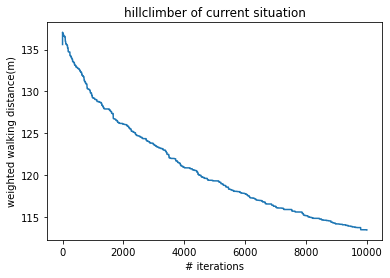

In [134]:
temporary = pd.DataFrame.from_dict(dct_hillclimber, orient='index')
plt = temporary[0].plot(kind='line', title='hillclimber of current situation')
plt.set_xlabel('# iterations')
plt.set_ylabel('weighted walking distance(m)')

In [135]:
temporary.to_csv('20200408-hillclimber-10K.csv')